# Bird Species Classifier for AML project using Keras/TensorFlow
## University of Vienna, SS 2022

In [46]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# To search directories
import os
import glob

# To visualize data
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')

In [47]:
print("TensorFlow Version: ", tf.__version__)
print("Keras Version: ", keras.__version__)

TensorFlow Version:  2.6.4
Keras Version:  2.6.0


In [48]:
# Source: Tensorflow documentation
gpus = tf.config.list_physical_devices('GPU')
print("GPU list:", gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

GPU list: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


#### Virtual GPU which can be controlled
The second method is to configure a virtual GPU device with tf.config.set_logical_device_configuration and set a hard limit on the total memory to allocate on the GPU.
~ [Link](https://www.tensorflow.org/guide/gpu#:~:text=The%20second%20method%20is%20to%20configure%20a%20virtual%20GPU%20device%20with%20tf.config.set_logical_device_configuration%20and%20set%20a%20hard%20limit%20on%20the%20total%20memory%20to%20allocate%20on%20the%20GPU.)

In [49]:
"""gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)""";

# 1. Examine and understand data
## CSV data
The ``birds.csv`` contains information of the dataset. Let's look into the structure of the data.

In [50]:
# Create a dataframe from the csv
birds_df = pd.read_csv("../input/100-bird-species/birds.csv")
# clean column names
birds_df.columns = [col.replace(' ', '_').lower() for col in birds_df.columns]
birds_df.head()

,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [51]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62388 entries, 0 to 62387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  62388 non-null  int64 
 1   filepaths    62388 non-null  object
 2   labels       62388 non-null  object
 3   data_set     62388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [52]:
birds_df.value_counts("data_set").head()

data_set
train    58388
test      2000
valid     2000
dtype: int64

In [53]:
# Frequency of bird species in the whole dataset
print("|species | f|")
birds_df.value_counts("class_index")

|species | f|


class_index
224    259
144    243
287    243
363    227
396    224
      ... 
129    130
122    130
346    130
326    130
62     130
Length: 400, dtype: int64

In [54]:
# Look at csv entries for one single bird

#mask = birds_df['labels'].str.contains("ABBOTTS BABBLER") # Search for text fragment
#mask = birds_df.query('labels == "ABBOTTS BABBLER"') # query for name (case sensitive!)
mask = birds_df.loc[birds_df['class_index'] == 0]
print(mask.value_counts("data_set"))
mask

data_set
train    166
test       5
valid      5
dtype: int64


,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
60388,0,valid/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,valid
60389,0,valid/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,valid
60390,0,valid/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,valid
60391,0,valid/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,valid


## Image data

In [55]:
# File directories
root_dir = "../input/100-bird-species"
train_dir = "../input/100-bird-species/train"
valid_dir = "../input/100-bird-species/valid"
test_dir = "../input/100-bird-species/test"

### Plot a bird image

../input/100-bird-species/valid/MALLARD DUCK/5.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/1.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/4.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/3.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/2.jpg
File shape:  (224, 224, 3) 



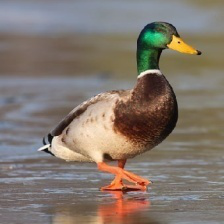

In [56]:
def showFirstBird(bird_name="MALLARD DUCK"):
    """
    Print out file paths of images in the valid_dir and show the first image of a given species.
    """
    import glob
    img_files = []
    for img in glob.glob(os.path.join(valid_dir, bird_name)+"/*"):
        img_files.append(img)
        
    for i in img_files:
        print(i) # Print file path
        ifile = tf.io.read_file(i) # Reads the contents of file
        img_dec = tf.io.decode_image(ifile) # Decodes an image file
        print("File shape: ", img_dec.shape, "\n")
        
    img = PIL.Image.open(str(img_files[0]))
    return img
    
showFirstBird()

# 2. Create a dataset for the model
## Generate tf.data.Dataset objects from a directory
Take image files from a directory on disk and generate a ``tf.data.Dataset`` for train, validation and test dataset. ``image_dataset_from_directory()`` is a special TensorFlow data generator function.  

"""
Achieving peak performance requires an efficient input pipeline that delivers data for 
the next step before the current step has finished. The tf.data API helps to build flexible 
and efficient input pipelines.
~ https://www.tensorflow.org/guide/data_performance
"""

In [57]:
IMAGE_SIZE=(150,150) # original size: 224,224 # Resolution decreased to speed up training time
BATCH_SIZE=32 # default=32
SEED=42
np.random.seed(42)
tf.random.set_seed(42)

train_data = image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.5,
    label_mode='categorical',
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE,
    subset='training',
    seed=SEED,
    shuffle=True   # default
)
class_names = train_data.class_names
num_classes = len(class_names)
#print("Class names: ", class_names[:5])

valid_data = image_dataset_from_directory(
    directory=valid_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=True   # default
)

test_data = image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    shuffle=False
)
len(train_data)

Found 58388 files belonging to 400 classes.
Using 29194 files for training.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


913

## Configure the dataset for performance
To prevent I/O blocking while retrieving data from disk we use buffered prefetching.  

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used 
to decouple the time when data is produced from the time when data is consumed. In particular, 
the transformation uses a background thread and an internal buffer to prefetch elements from 
the input dataset ahead of the time they are requested. The number of elements to prefetch 
should be equal to (or possibly greater than) the number of batches consumed by a single training step. 
You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the 
tf.data runtime to tune the value dynamically at runtime.

 ~ https://www.tensorflow.org/guide/data_performance

In [58]:
train_data_pf = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
valid_data_pf = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE) ,
test_data_pf = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# 3. Create Model 
## Define model architecture

In [59]:
INPUT_SHAPE=(150, 150, 3)

model = tf.keras.models.Sequential([

    # handy input layer
    layers.Input(INPUT_SHAPE),

    # convolution layers
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),    

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),    

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), activation='relu'),
    #layers.MaxPooling2D(pool_size=2),
    layers.BatchNormalization(),

    # Last fully-connected layer
    layers.Flatten(input_shape=INPUT_SHAPE),
    #GlobalAveragePooling2D(input_shape=INPUT_SHAPE),
    layers.Dropout(0.2), # NEXT RUN
    layers.BatchNormalization(),
    layers.Dense(units=num_classes, activation='softmax')
])
keras.backend.clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 256)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        7

## Compile model
- Cross-entropy is the default loss function to use for multi-class classification problems. ~ [Link](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/#:~:text=Cross%2Dentropy%20is%20the%20default%20loss%20function%20to%20use%20for%20multi%2Dclass%20classification%20problems.)
    - IMPORTANT: The function requires that the output layer is configured with an n nodes (one for each class), in this case three nodes, and a ‘softmax‘ activation in order to predict the probability for each class.

In [60]:
# Configure optimizer
opt = optimizers.Adam(
    learning_rate=1e-3,  # DEFAULT: 0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

model.compile(
    optimizer=opt,  #'adam',
    loss='categorical_crossentropy', # standard for multi-class clf    
    metrics=['accuracy']
)

### Plot the model architecture

In [61]:
dot_img_file = '/tmp/'+model.name+'.png'
model_img = tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
#model_img

# 5. Train model

In [62]:
EPOCHS = 20
STEPS = int(len(train_data_pf))
VALIDATION_STEPS = 5 #int(len(valid_data_pf)*0.1)   # at the end of each epoch

header=f"|Epochs: {EPOCHS} | Steps: {STEPS} | Validation steps: {VALIDATION_STEPS} |"
stars="\n"+("*"*len(header)); print(header, stars)

history = model.fit(
    train_data_pf,
    validation_data=valid_data_pf,
    validation_steps=VALIDATION_STEPS, 
    epochs=EPOCHS,
    workers=-1, verbose=1, callbacks=[
        tf.keras.callbacks.EarlyStopping( 
            #Prevent overfitting through early stopping
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=1
)])
model.save("birds.h5")

|Epochs: 20 | Steps: 913 | Validation steps: 5 | 
************************************************
Epoch 1/20


2022-06-01 07:53:28.932693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-01 07:53:30.728765: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


913/913 [==============================] - 106s 106ms/step - loss: 4.8095 - accuracy: 0.0872 - val_loss: 4.2279 - val_accuracy: 0.1312
Epoch 2/20
913/913 [==============================] - 49s 53ms/step - loss: 3.4763 - accuracy: 0.2592 - val_loss: 3.1236 - val_accuracy: 0.3125
Epoch 3/20
913/913 [==============================] - 49s 53ms/step - loss: 2.8708 - accuracy: 0.3705 - val_loss: 2.7205 - val_accuracy: 0.4563
Epoch 4/20
913/913 [==============================] - 49s 53ms/step - loss: 2.4757 - accuracy: 0.4397 - val_loss: 1.7582 - val_accuracy: 0.5875
Epoch 5/20
913/913 [==============================] - 50s 54ms/step - loss: 2.2071 - accuracy: 0.4921 - val_loss: 1.7916 - val_accuracy: 0.5813
Epoch 6/20
913/913 [==============================] - 50s 54ms/step - loss: 1.9864 - accuracy: 0.5322 - val_loss: 2.0754 - val_accuracy: 0.5125
Epoch 7/20
913/913 [==============================] - 49s 54ms/step - loss: 1.8234 - accuracy: 0.5613 - val_loss: 1.7014 - val_accuracy: 0.5813
E

In [63]:
# Evaluation
scores = model.evaluate(test_data_pf, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

63/63 [==============================] - 6s 96ms/step - loss: 1.8599 - accuracy: 0.5755
Accuracy: 57.55%


# 6. Evaluation
## Model Results
### Visualize Training

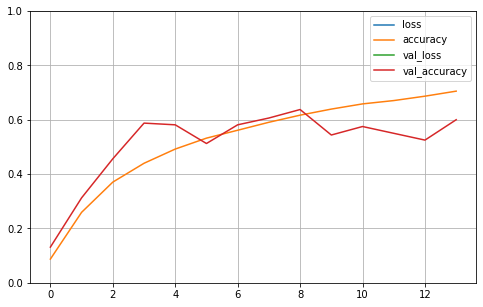

In [66]:
# Plot function from lecture
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig("keras_learning_curves_plot")
plt.show()

In [68]:
scores = model.evaluate(test_data_pf, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

63/63 [==============================] - 2s 35ms/step - loss: 1.8599 - accuracy: 0.5755
Accuracy: 57.55%


---
# README
after the first meeting

### Aufteilung
- keras tensorflow - Clemens
- pytorch - Jakob
- PCA + preprocessing - Lena 


### Methoden 
- pca?
- image segementation
- Wie laden wir die Bilder von der CSV ins Notebook?
- Wieviele Datenreihen brauchen wir? 
data set
| train    58388 | test      2000 | valid     2000 |


**Take aways from [Gabriel Atkin's Age Prediction From Facial Images](https://www.youtube.com/watch?v=9AnCNBL8c6Q&t=661s):**
- Recurrent feature extraction
- Flatten layer
    - layers.Flatten()(x) # sometimes too many features
    - layers.GlobalAveragePooling2D()(x) # average across the first 2 dimensions

"""    # convolution layer
    layers.Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(),
    
    # convolution layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # convolution layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    # convolution layer
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),"""

### Links:
- TF model.fit() -> https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- ...

**Optimizers:**
- Adam: a sensible default optimizer
- Nadam (Nesterov-accelerated Adam)
- RMSProp (oftentimes used for regression) -> keras default

# Links
## Good Notebook for reference
### https://www.kaggle.com/code/ashwinshetgaonkar/bird-classifier-tensorflow-beginner

## Learn TensorFlow in this notebook
### http://bit.ly/2lXXdw5